In [1]:
import pickle as pkl

import pandas as pd
from data_utils import (
    results2df,
    return_ct_location_segments,
)
from plot_utils import (
    plot_aggregated_behavior_distribution,
    plot_camera_locations_distribution,
    plot_multiple_behavior_distributions,
)

**Load annotations and results**

In [2]:
# Relevant paths
train_results_file = (
    "../dataset/results/model=slow_r50-w-negatives_e=100_split=train.pkl"
)
val_results_file = "../dataset/results/model=slow_r50-w-negatives_e=100_split=val.pkl"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segments.txt"

In [3]:
with open(
    train_results_file,
    "rb",
) as f:
    train_data = pkl.load(f)

with open(val_results_file, "rb") as f:
    val_data = pkl.load(f)

metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

In [4]:
# This will return dfs with preds, feats, labels, and all metadata
train_df, val_df = results2df(train_data, val_data, metadata_df)

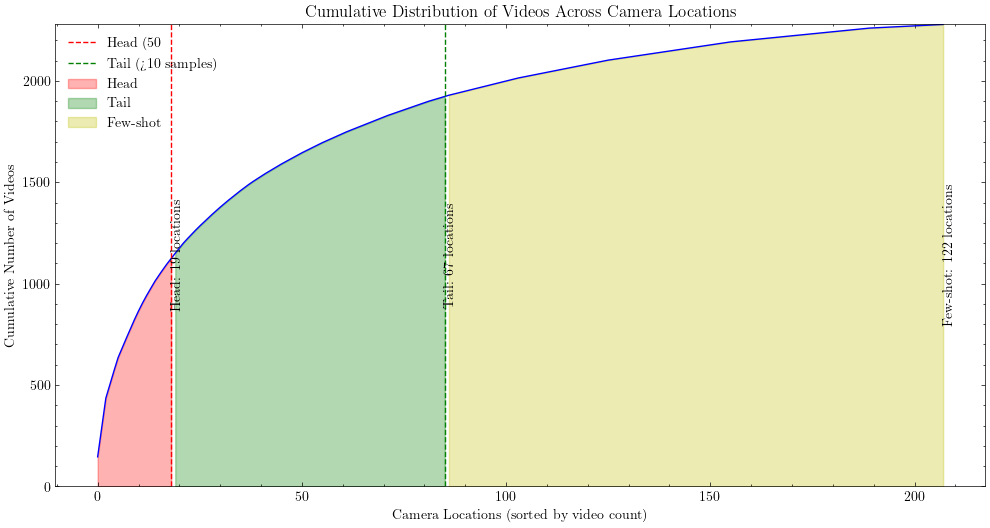

In [9]:
plot_camera_locations_distribution(train_df, head=50, tail=5, use_proportion=False)

In [16]:
# Get the location segments
h_df, t_df, f_df = return_ct_location_segments(train_df, head=50, tail=10)

# Merge with original dataframe
h_df = h_df.merge(train_df, on="utm", how="left")
t_df = t_df.merge(train_df, on="utm", how="left")
f_df = f_df.merge(train_df, on="utm", how="left")

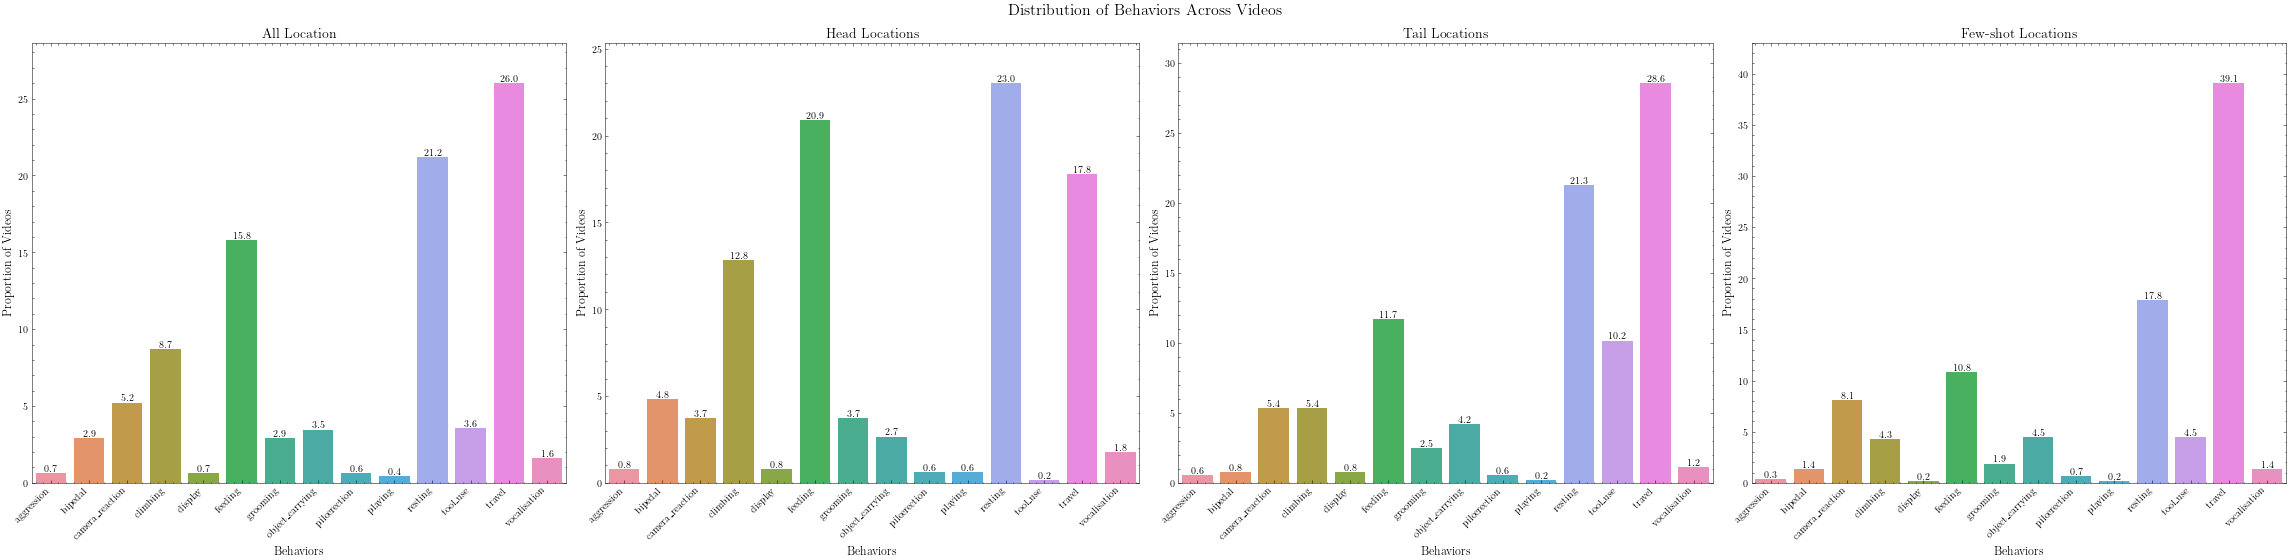

In [17]:
plot_multiple_behavior_distributions(
    [train_df, h_df, t_df, f_df],
    behaviours,
    annot="proportion",
    titles=["All Location", "Head Locations", "Tail Locations", "Few-shot Locations"],
)

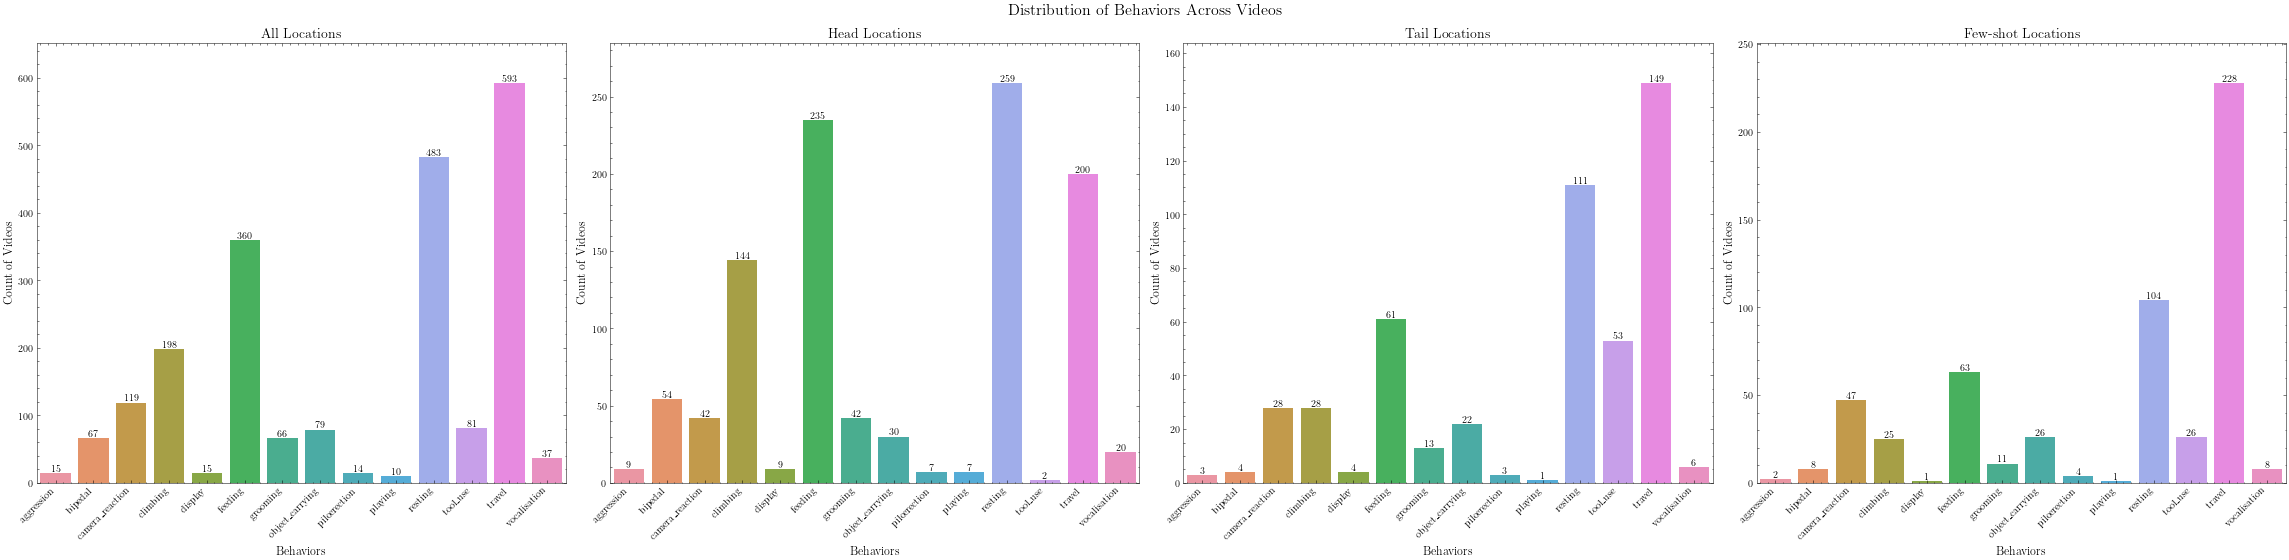

In [18]:
plot_multiple_behavior_distributions(
    [train_df, h_df, t_df, f_df],
    behaviours,
    annot="count",
    titles=["All Locations", "Head Locations", "Tail Locations", "Few-shot Locations"],
)

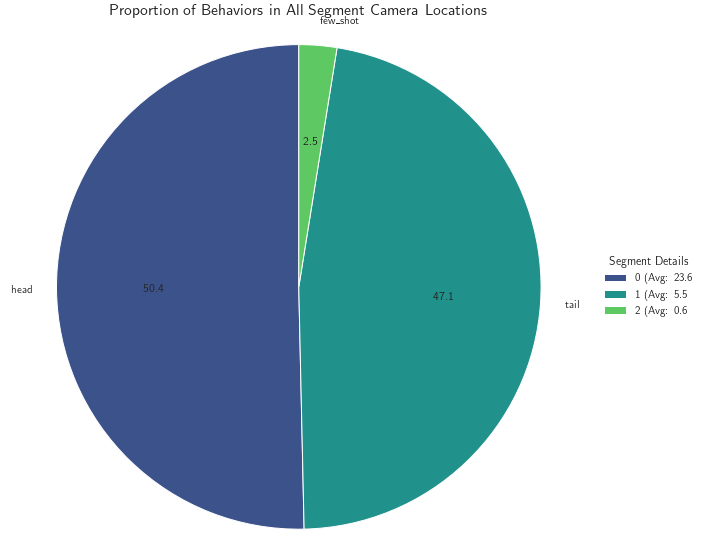

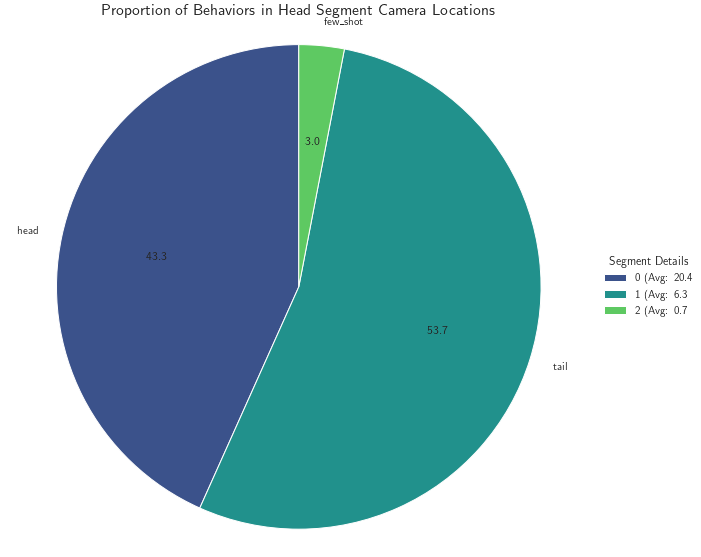

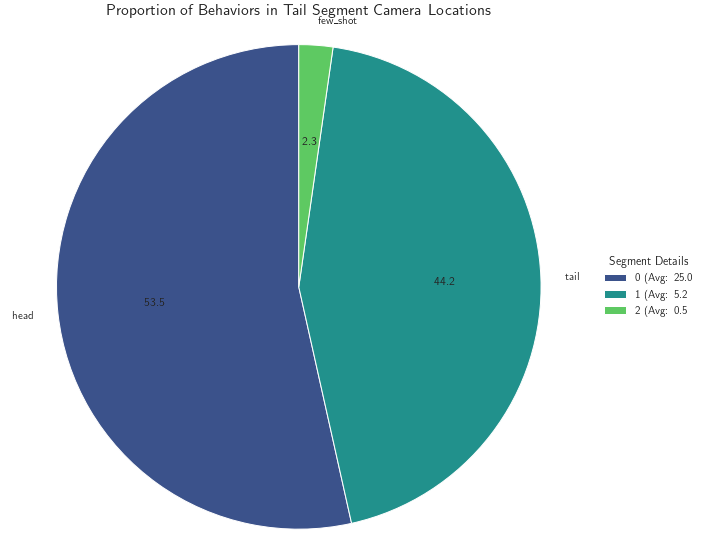

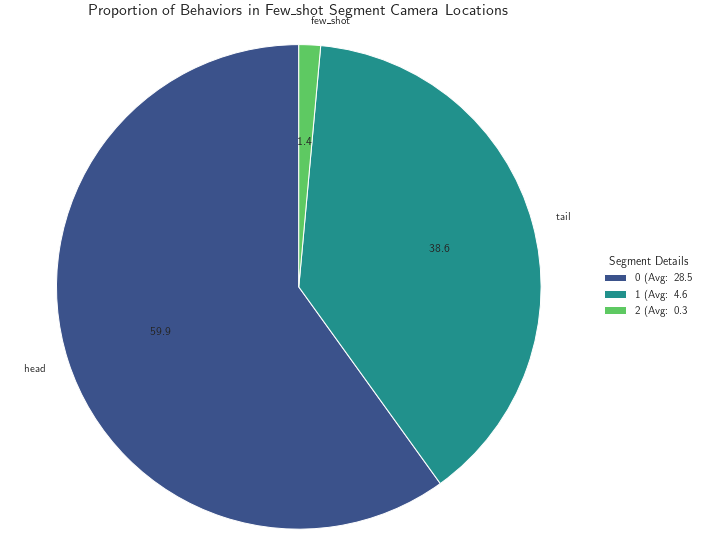

In [19]:
all_df = plot_aggregated_behavior_distribution(
    train_df, behaviours, segments, plot_type="pie"
)

plot_aggregated_behavior_distribution(
    h_df, behaviours, segments, plot_type="pie", segment="head"
)
plot_aggregated_behavior_distribution(
    t_df, behaviours, segments, plot_type="pie", segment="tail"
)
plot_aggregated_behavior_distribution(
    f_df, behaviours, segments, plot_type="pie", segment="few_shot"
)